# POP Tracer Budget

An integral form of a tracer $c \mid \,c \in \{\theta, S\} $ can be written as:

$$
\mathcal{V} \frac{\partial c}{\partial t} = \langle Q_{adv}\rangle + \langle Q_{diff}\rangle + \langle Q_{srf\_flx}\rangle + \langle Q_{resid}\rangle
$$


In [1]:
import os 
import xarray as xr
import numpy as np
from dask.diagnostics import ProgressBar
from glob import glob
%matplotlib inline
np.warnings.filterwarnings('ignore')

In [2]:
TRACER = "TEMP"
COMPSET = "B20TRC5CNBDRD"
dir_lens = "/*/*/CESM-LENS"
ens_member = 4
realm = "ocn"
freq = "mon"
ens_str = "{:0>3d}".format(ens_member)
klo = 0
khi = 25
tlo = 491   #912
thi = 611   #1032

In [3]:
# use to sort by suffix (date)
def get_suffix(x):
    return x[-17:]

# devolve lista ordenada pelo label de tempo do arquivo
def get_filelist (basedir, scenario, freq, realm, varname):
    filelist = glob(basedir + "/" + scenario + "/" + realm + "/" +\
                    freq + "/" + varname + "/b.e11." + scenario + "*.nc")
    return (sorted(filelist,key=get_suffix))

# devolve um arquivo/lista de arquivos de uma variavel e ens_member
def get_filemember (basedir, scenario, freq, realm, ens_member, varname):
    return sorted(glob(basedir + "/" + scenario + "/" + realm + "/" + freq + "/" + \
                varname + "/b.e11." + scenario + ".f09_g16." + ens_member + ".pop.h.*.nc"), key=get_suffix)

# recebe um arquivo/lista de arquivos e devolve um dataset
def read_cesm_pop (file, chunk_sz):
    return xr.open_mfdataset(file,decode_times=False,mask_and_scale=True,\
                             concat_dim="time",data_vars="minimal",chunks={'time': chunk_sz})

In [4]:
file_tracer = get_filemember(dir_lens,'*',freq,realm,ens_str,TRACER)
ds_tracer = read_cesm_pop (file_tracer, 60)
dz = ds_tracer['dz'];
tarea = ds_tracer['TAREA']
kmt = ds_tracer['KMT']
# select 120 months
temp = ds_tracer[TRACER].isel(time=slice(tlo,thi))
time_bound = ds_tracer["time_bound"].isel(time=slice(tlo,thi))

In [5]:
# decode time axis (cesm/pop)
def pop_decode_time (x, time_bound): 
    t0 = x.time.load()
    x = x.drop('time')
    t0 = t0.drop('time')
    del(t0.attrs['bounds'])
    t1 = (time_bound[:,0]+time_bound[:,1])*0.5
    t1 = t1.drop('time')
    t0.values = t1.values
    x = x.assign_coords(time=t0)
    return xr.decode_cf(x.to_dataset(),decode_times=True)[x.name]

# recebe uma variavel x (monthly) e devolve as medias anuais
def month_to_annual (x):
    return x.groupby('time.year').mean('time')

# remove a media climatologica de var
def rmMonAnnCyc (var):
    climatology = var.groupby('time.month').mean('time')
    anomalies = (var.groupby("time.month") - climatology).squeeze()
    return anomalies.drop("month")

## Volume, continent mask, surface t-area cell

In [6]:
def tracer_budget_vol3d (tarea, dz, kmt):
    """
    Arguments: cell area, cell height, max vertical indx
    Returns global 3D volume DataArray: vold3(nz,ny,nx) dtype=float64
    NOTE: does not include SSH variations
    """
    vol3d = (dz*tarea.astype('float64')).load()
    for i in range(dz.shape[0]):
        vol3d[i,:,:] = vol3d[i].where(kmt > i, 0.)
    vol3d.attrs = {'units' : 'cm3', 'long_name' : 'Tcell volume'}
    vol3d = vol3d.drop(('ULAT','ULONG'))
    vol3d.name = "vol3d"
    return vol3d
#*****************************************************************************#
def tracer_budget_mask2d (region_mask, sel_area = 0):
    """
    Return surface mask: if ocean than 1 else nan
    """
    mask = region_mask
    mask = mask.where(region_mask != sel_area,np.nan)
    return (mask/mask)
#*****************************************************************************#
def tracer_budget_mask3d (var3d):
    """
    Return volume mask: if ocean than 1 else nan
    """
    mask3d = var3d/var3d
    mask3d.attrs = {'units' : '1 / np.nan', 'long_name' : 'mask3d'}
    return mask3d.where(mask3d != 0.,np.nan)
#*****************************************************************************#
mask3d = tracer_budget_mask3d(temp[0])
vol3d = tracer_budget_vol3d(tarea,dz,kmt)
mask2d = tracer_budget_mask2d(ds_tracer['REGION_MASK'])
area2d = tarea*mask2d

## Volume integral

$ \langle c \rangle = \int_v c \, dV$

In [7]:
def tracer_budget_var3d_zint_map (tracer, vol3d, klo=0, khi=25):
    """
    Arguments: var4d tracer(t,z,y,x), vol3d cell volume, 
               klo : lowest k index, khi : highest k index
    Returns a 2d tracer map vertical integrated
    """
    units = tracer.units + " cm^3"
    description = "Int_V {" + tracer.name + "} dV"
    long_name = tracer.name + " vertical average"
    attr = {"long_name" : long_name, "units" : units, "description": description, \
            "k_range" : str(klo)+" - "+str(khi)}
    var = tracer.isel(z_t=slice(klo,khi)) * vol3d.isel(z_t=slice(klo,khi))
    var_zint_map = var.sum(dim="z_t")
    var_zint_map.attrs = attr
    var_zint_map.name = tracer.name + "_zint" 
    var_zint_map = var_zint_map.drop(("ULONG","ULAT"))
    return var_zint_map.where(var_zint_map != 0.)

<xarray.DataArray 'TEMP_zint' (time: 120, nlat: 384, nlon: 320)>
dask.array<shape=(120, 384, 320), dtype=float64, chunksize=(49, 384, 320)>
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * time     (time) float64 7.158e+05 7.158e+05 ... 7.194e+05 7.194e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    TEMP vertical average
    units:        degC cm^3
    description:  Int_V {TEMP} dV
    k_range:      0 - 25

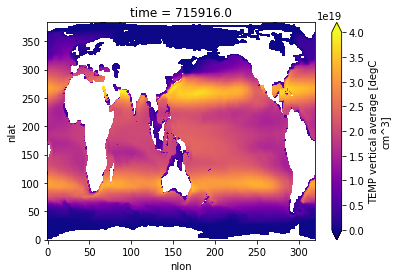

In [8]:
#*****************************************************************************#
temp_zint_map = tracer_budget_var3d_zint_map (temp,vol3d,klo,khi)
temp_zint_map.isel(time=5).plot(cmap="plasma",vmin=0,vmax=4e19);
temp_zint_map

## Tracer tendency: $\frac{\partial \langle c \rangle}{\partial t} $

Compute appoximate tracer total tendency (vertical integrated)

In [9]:
def tracer_budget_tend_appr (TRACER, time_bnd, var_zint):
    """
    Computes approximate TRACER budget tendency given vertically-integrated POP
    TRACER based on differencing successive monthly means
    NOTE: Assumes monthly POP output with timestamp at end-of-month
          rather than mid-month; assumes time has dimension "days".
    Obs: from tracer_budget_util.ncl
    """
    secperday = 60.*60*24
    # days in each month * sec/day 
    dt = (time_bnd.isel(d2=1) - time_bnd.isel(d2=0))*secperday
    units = var_zint.units + "/s"
    
    long_name = var_zint.long_name + " tendency"
    attr = {"long_name" : long_name, "units" : units}
    
    # apprx to end of month 
    # X = [X_t + X_(t+1)]/2
    X = (var_zint + var_zint.shift(time=-1))*0.5
    
    # X = X_t - X_(t-1)
    dX = X - X.shift(time=1)
    
    #units per seconds
    var_zint_tend = dX/dt
    var_zint_tend.attrs = attr
    var_zint_tend.name = TRACER.lower() + "_tend"
    return var_zint_tend

<xarray.DataArray 'temp_tend' (time: 120, nlat: 384, nlon: 320)>
dask.array<shape=(120, 384, 320), dtype=float64, chunksize=(1, 384, 320)>
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * time     (time) object 1960-12-16 12:00:00 ... 1970-11-16 00:00:00
Dimensions without coordinates: nlat, nlon

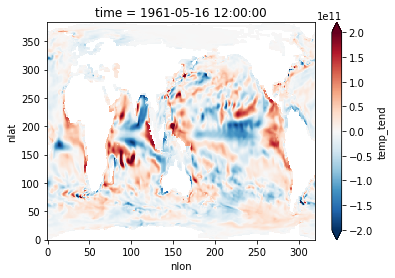

In [10]:
#*****************************************************************************#
temp_tend = tracer_budget_tend_appr(TRACER, time_bound, temp_zint_map)
temp_tend_anom = rmMonAnnCyc(pop_decode_time(temp_tend, time_bound))
temp_tend_anom.isel(time=5).plot(vmin=-2e11,vmax=2e11,cmap="RdBu_r");
temp_tend_anom

## Divergence: resolved lateral advection


### $ - \int_z  \nabla . \langle Q_{horiz} \rangle\, dz $

* Tracer: TEMP

    Horizontal Heat Flux [ $degC \,s^{-1}$ ]
    
    $\, Q_{horiz} = (\, UET,VNS \,)$

In [11]:
def tracer_budget_lat_adv_resolved (f_ue, f_vn, TRACER, vol3d, \
                                    klo=0, khi=25, tlo=490, thi=610, z_int=True):
    """
    compute tracer lateral advection integral 
    based on tracer_budget_adv.ncl
    """
    if TRACER == "TEMP":
        var_name1 = "UET"
        var_name2 = "VNT"
        units = "degC cm^3/s"
    else:
        var_name1 = "UES"
        var_name2 = "VNS"
        units = "PSU cm^3/s"
        
    long_name = "lateral advective flux (resolved)"
    description = "Int_z{-Div[<"+var_name1+">, <"+var_name2+">]}"
    
    # read tracer associate variable
    ds1 = read_cesm_pop (f_ue, 60)
    ds2 = read_cesm_pop (f_vn, 60)
    ue = (ds1[var_name1]).isel(z_t=slice(klo,khi),time=slice(tlo,thi))
    vn = (ds2[var_name2]).isel(z_t=slice(klo,khi),time=slice(tlo,thi))
    zlo = (ds1["z_w"]).isel(z_w=klo).values
    zhi = (ds1["z_w"]).isel(z_w=(khi-1)).values
    attr = {"long_name" : long_name, "units" : units, "description" : description,\
            "k_range" : str(klo)+" - "+str(khi),\
            "depth_range" :  "{0:3.2f} - {1:3.2f} m".format((zlo/100),(zhi/100))}
    # vol3d
    vol = vol3d.isel(z_t=slice(klo,khi))
    # e.g.: degC cm^3/s
    ue = ue*vol  # Tcell_(i,j)
    vn = vn*vol  # Tcell_(i,j)
    # shift grid:
    uw = ue.roll(nlon=1,roll_coords=False) # Tcell_(i-1,j)
    vs = vn.roll(nlat=1,roll_coords=False) # Tcell_(i,j-1)
    # Div [du/dx + dv/dy]
    hdiv = (uw-ue) + (vs-vn)
    # vertical integration
    if z_int:
        var_lat_adv_res_map = hdiv.sum(dim="z_t",keep_attrs=True)
    else:
        var_lat_adv_res_map = hdiv
    var_lat_adv_res_map.attrs = attr
    var_lat_adv_res_map.name = TRACER.lower() + "_lat_adv_res"
    var_lat_adv_res_map = var_lat_adv_res_map.drop(("ULONG","ULAT"))
    return var_lat_adv_res_map.where(var_lat_adv_res_map != 0.)

<xarray.DataArray 'temp_lat_adv_res' (time: 120, nlat: 384, nlon: 320)>
dask.array<shape=(120, 384, 320), dtype=float64, chunksize=(1, 384, 320)>
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * time     (time) object 1960-12-16 12:00:00 ... 1970-11-16 00:00:00
Dimensions without coordinates: nlat, nlon

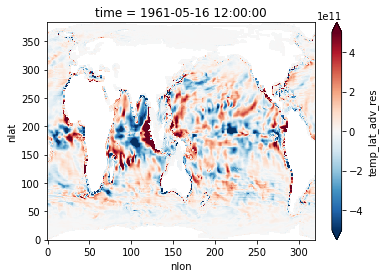

In [12]:
f_ue = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,"UET")
f_vn = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,"VNT")
#*****************************************************************************#
temp_lat_adv_res = tracer_budget_lat_adv_resolved(f_ue, f_vn, TRACER, vol3d,\
                                                  klo, khi, tlo, thi)
temp_lat_adv_res_anom = rmMonAnnCyc(pop_decode_time(temp_lat_adv_res, time_bound))
temp_lat_adv_res_anom.isel(time=5).plot(vmin=-5e11,vmax=5e11,cmap="RdBu_r")
temp_lat_adv_res_anom

## Divergence: resolved vertical advection
### $ - \int_z \langle Q_{vert} \rangle \, dz $

* Tracer: TEMP

    Vertical Heat Flux [ $degC \,s^{-1}$ ]
    
    $\, Q_{vert} =  WTT $

In [13]:
def tracer_budget_vert_adv_resolved (f_wt, TRACER, vol3d,\
                                     klo=0, khi=25, tlo=912, thi=1032, z_int=True):
    """
    tracer vertical advection integral
    Obs. klo==0 -> wtt=0. => klo=1; khi => khi+1 (max:=59)
    """
    if TRACER == "TEMP":
        var_name = "WTT"
        units = "degC cm^3/s"
    else:
        var_name = "WTS"
        units = "PSU cm^3/s"
    
    long_name = "vertical advective flux (resolved)"
    description = "Int_z{-d[<"+var_name+">]/dz}"
    attr = {"long_name" : long_name, "units" : units, "description" : description,\
            "k_range" : str(klo)+" - "+str(khi)}
    # read tracer associate variable
    ds1 = read_cesm_pop (f_wt, 60)
    wt = ds1[var_name].isel(time=slice(tlo,thi))
    wt = wt.rename({"z_w_top" : "z_t"})
    wt["z_t"] = vol3d.z_t
    # e.g. degC cm^3/s
    wt = wt*vol3d
    if z_int:
        var_top = wt.isel(z_t=klo)
        var_bottom = wt.isel(z_t=khi+1)
        # since it has NaN (NOTE: carefull with zeros)
        var_bottom = var_bottom.where(~np.isnan(var_bottom),0.)
        # vertical convergence
        var_vert_adv_res_map = (var_bottom - var_top)
    else:
        wt_z  = wt.shift(z_t=-1).fillna(0.)
        var_vert_adv_res_map = wt_z.isel(z_t=slice(klo,khi)) - wt.isel(z_t=slice(klo,khi))

    var_vert_adv_res_map.attrs = attr
    var_vert_adv_res_map.name = TRACER.lower()+"_vert_adv_res"
    var_vert_adv_res_map = var_vert_adv_res_map.drop(("ULONG","ULAT"))
    return var_vert_adv_res_map

['/chuva/db2/CESM-LENS/B20TRC5CNBDRD/ocn/mon/WTT/b.e11.B20TRC5CNBDRD.f09_g16.004.pop.h.WTT.192001-200512.nc']


<xarray.DataArray 'temp_vert_adv_res' (time: 120, nlat: 384, nlon: 320)>
dask.array<shape=(120, 384, 320), dtype=float64, chunksize=(49, 384, 320)>
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * time     (time) float64 7.158e+05 7.158e+05 ... 7.194e+05 7.194e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    vertical advective flux (resolved)
    units:        degC cm^3/s
    description:  Int_z{-d[<WTT>]/dz}
    k_range:      0 - 25

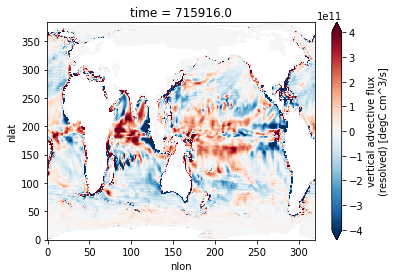

In [14]:
f_wt = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,"WTT")
print(f_wt)
#*****************************************************************************#
temp_vert_adv_res = tracer_budget_vert_adv_resolved (f_wt, TRACER, vol3d,\
                                                     klo, khi, tlo, thi)
temp_vert_adv_res.isel(time=5).plot(vmin=-4e11,vmax=4e11,cmap="RdBu_r")
temp_vert_adv_res

## Divergence: lateral mixing from submesoscale eddies and isopycnal diffusion
### $ - \int_z \nabla . \langle Q_{hdiff} \rangle \, dz $

* Tracer: TEMP

    Horizontal Diffusion Flux [ $degC \,s^{-1}$ ]
    
    $\, Q_{hdiff} = (\,HDIFE\_TEMP,HDIFN\_TEMP\,)$

In [15]:
def tracer_budget_hmix (f_e, f_n, TRACER, vol3d,\
                        klo=0, khi=25, tlo=912, thi=1032, z_int=True):
    """
    tracer horizontal mixing
    compute tracer hmix integrals from Horiz Diffusive Fluxes
    vertical fluxes are positive up
    """
    if TRACER == "TEMP":
        units = "degC cm^3/s"
    else:
        units = "PSU cm^3/s"
    #diffusive flux variable names
    var_name1 = "HDIFE_"+TRACER
    var_name2 = "HDIFN_"+TRACER
    
    long_name = "lateral diffusive flux (resolved)"
    description = "Int_z{-Div[<"+var_name1+">, <"+var_name2+">]}"
    # read tracer associate variable
    ds1 = read_cesm_pop (f_e, 60) 
    ds2 = read_cesm_pop (f_n, 60) 
    
    ue = (ds1[var_name1]).isel(z_t=slice(klo,khi),time=slice(tlo,thi))
    vn = (ds2[var_name2]).isel(z_t=slice(klo,khi),time=slice(tlo,thi))
    zlo = (ds1["z_w"]).isel(z_w=klo).values
    zhi = (ds1["z_w"]).isel(z_w=(khi-1)).values
    
    attr = {"long_name" : long_name, "units" : units, "description" : description,\
            "k_range" : str(klo)+" - "+str(khi),\
            "depth_range" :  "{0:3.2f} - {1:3.2f} m".format((zlo/100),(zhi/100))}
    # vol3d
    vol = vol3d.isel(z_t=slice(klo,khi))
    # e.g.: degC cm^3/s
    ue = ue*vol  # Tcell_(i,j)
    vn = vn*vol  # Tcell_(i,j)
    
    # shift
    uw = ue.roll(nlon=1,roll_coords=False)  # Tcell_(i-1,j)
    vs = vn.roll(nlat=1,roll_coords=False)  # Tcell_(i,j-1)
    
    # Divergence
    hdiv = (uw-ue) + (vs-vn)
    #hdiv = (ue-uw) + (vn-vs)
    # copy coordinates
    #hdiv = hdiv.assign_coords(TLAT=ue.coords.get("TLAT"))
    # vertical integration
    if z_int:
        var_lat_mix_res_map = hdiv.sum(dim="z_t")
    else:
        var_lat_mix_res_map = hdiv
    var_lat_mix_res_map.attrs = attr
    var_lat_mix_res_map.name = TRACER.lower() + "_lat_mix_res"
    var_lat_mix_res_map = var_lat_mix_res_map.drop(("ULONG","ULAT"))
    return var_lat_mix_res_map.where(var_lat_mix_res_map != 0.)

<xarray.DataArray 'temp_lat_mix_res' (time: 120, nlat: 384, nlon: 320)>
dask.array<shape=(120, 384, 320), dtype=float64, chunksize=(49, 384, 320)>
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * time     (time) float64 7.158e+05 7.158e+05 ... 7.194e+05 7.194e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    lateral diffusive flux (resolved)
    units:        degC cm^3/s
    description:  Int_z{-Div[<HDIFE_TEMP>, <HDIFN_TEMP>]}
    k_range:      0 - 25
    depth_range:  0.00 - 259.16 m

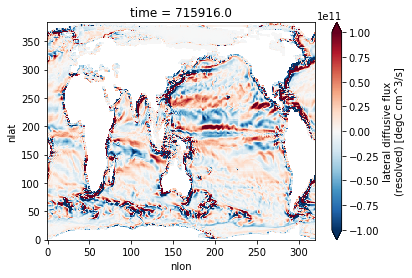

In [16]:
f_hdife = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,"HDIFE_TEMP")
f_hdifn = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,"HDIFN_TEMP")
#*****************************************************************************#
temp_lat_mix = tracer_budget_hmix (f_hdife, f_hdifn, TRACER, vol3d,\
                                   klo, khi, tlo, thi)
temp_lat_mix.isel(time=5).plot(vmin=-1e11,vmax=1e11,cmap="RdBu_r");
temp_lat_mix

## Divergence: diapycnal diffusion
Computes vertical integral of diabatic vertical mixing ($DIA\_IMPVF\_$), i.e. KPP
### $ - \int_z \langle Q_{dia\_mix} \rangle \, dz $

* Tracer: TEMP

    Diabatic Implicit Vertical Mixing [ $degC\,cm\,s^{-1}$ ]
    
    $\, Q_{dia\_mix} =  DIA\_IMPVF\_TEMP $

In [17]:
def tracer_budget_dia_vmix (f_dia, TRACER, tarea, kmt, \
                            klo=0, khi=25, tlo=912, thi=1032, z_int=True):
    """
    Computes vertical integral of diabatic vertical mixing (DIA_IMPVF_), ie. KPP
    """
    if TRACER == "TEMP":
        units = "degC cm^3/s"
    else:
        units = "PSU cm^3/s"
    #variable name
    var_name = "DIA_IMPVF_"+TRACER
    
    long_name = "vertical (diabatic) mixing flux (resolved)"
    description = "Int_z{-d[<"+var_name+">]/dz}" 
    attr = {"long_name" : long_name, "units" : units, "description" : description,\
            "k_range" : str(klo)+" - "+str(khi)}
    
    # read tracer associate variable
    ds = read_cesm_pop (f_dia, 60)
    FIELD = ds[var_name].isel(time=slice(tlo,thi)) # degC cm/s
    FIELD = FIELD.rename({"z_w_bot" : "z_t"})
    FIELD["z_t"] = ds["z_t"]
    # degC cm^3/s
    FIELD = FIELD*tarea
    if z_int:
        # zero diffusive flux across sea surface -> 0 
        FIELD_TOP = FIELD.isel(z_t=klo)
        FIELD_BOT = FIELD.isel(z_t=khi)
        #tarea_bot = tarea.where(kmt > khi,0.)
        #tarea_top = tarea.where(kmt > klo,0.)
        #
        FIELD_BOT = FIELD_BOT.fillna(0.)
        var_vert_mix_map = -(FIELD_BOT - FIELD_TOP)
    else:
        diadiff_z = FIELD.shift(z_t=1).fillna(0.)
        var_vert_mix_map = diadiff_z.isel(z_t=slice(klo,khi)) - FIELD.isel(z_t=slice(klo,khi))

    var_vert_mix_map.name = TRACER.lower() + "_dia_vmix"
    var_vert_mix_map.attrs = attr
    var_vert_mix_map = var_vert_mix_map.drop(("ULONG","ULAT"))
    return var_vert_mix_map.where(var_vert_mix_map != 0.)

<xarray.DataArray 'temp_dia_vmix' (time: 120, nlat: 384, nlon: 320)>
dask.array<shape=(120, 384, 320), dtype=float64, chunksize=(49, 384, 320)>
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * time     (time) float64 7.158e+05 7.158e+05 ... 7.194e+05 7.194e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    vertical (diabatic) mixing flux (resolved)
    units:        degC cm^3/s
    description:  Int_z{-d[<DIA_IMPVF_TEMP>]/dz}
    k_range:      0 - 25

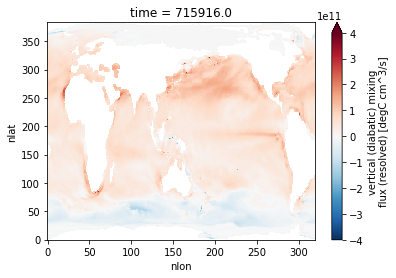

In [18]:
f_dia = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,"DIA_IMPVF_"+TRACER)
#*****************************************************************************#
temp_dia_vmix = tracer_budget_dia_vmix (f_dia,TRACER,tarea,kmt,klo,khi,tlo,thi)
temp_dia_vmix.isel(time=5).plot(vmin=-4e11,vmax=4e11,cmap="RdBu_r");
temp_dia_vmix

## Divergence: vertical mixing from submesoscale eddies and isopycnal diffusion
Computes vertical integral of adiabatic vertical mixing ($HDIFB\_$), i.e. GM+Submeso
### $ - \int_z \langle Q_{adi\_mix} \rangle \, dz $

* Tracer: TEMP

    Adiabatic Vertical Mixing [ $degC\,s^{-1}$ ]
    
    $\, Q_{adi\_mix} =  HDIFB\_TEMP $

In [19]:
def tracer_budget_adi_vmix (f_adi, TRACER, vol3d, \
                            klo=0, khi=25, tlo=912, thi=1032, z_int=True):
    """
    Computes vertical integral of adiabatic vertical mixing (HDIFB_), ie. GM+Submeso
    """
    if TRACER == "TEMP":
        units = "degC cm^3/s"
    else:
        units = "PSU cm^3/s"
    #variable name
    var_name = "HDIFB_"+TRACER
    
    long_name = "vertical (adiabatic) mixing flux (resolved)"
    description = "Int_z{-d[<"+var_name+">]/dz}" 
    attr = {"long_name" : long_name, "units" : units, "description" : description,\
            "k_range" : str(klo)+" - "+str(khi)}
    # read tracer associate variable
    ds = read_cesm_pop (f_adi, 60)
    FIELD = ds[var_name].isel(time=slice(tlo,thi)) # degC/s
    FIELD = FIELD.rename({"z_w_bot" : "z_t"})
    FIELD["z_t"] = vol3d.z_t
    FIELD = FIELD*vol3d
    if z_int:
    # zero diffusive flux across sea surface -> 0 
        FIELD_TOP = FIELD.isel(z_t=klo)
        FIELD_BOT = FIELD.isel(z_t=khi-1)
        var_vert_mix_map = -(FIELD_BOT.fillna(0.) - FIELD_TOP)
    else:
        hdifb_z = FIELD.shift(z_t=1).fillna(0.)
        var_vert_mix_map = hdifb_z.isel(z_t=slice(klo,khi)) - FIELD.isel(z_t=slice(klo,khi)).fillna(0.)

    var_vert_mix_map.attrs = attr
    var_vert_mix_map.name = TRACER.lower() + "_adi_vmix"
    var_vert_mix_map = var_vert_mix_map.drop(("ULONG","ULAT"))
    return var_vert_mix_map.where(var_vert_mix_map != 0.)

<xarray.DataArray 'temp_adi_vmix' (time: 120, nlat: 384, nlon: 320)>
dask.array<shape=(120, 384, 320), dtype=float64, chunksize=(49, 384, 320)>
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * time     (time) float64 7.158e+05 7.158e+05 ... 7.194e+05 7.194e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    vertical (adiabatic) mixing flux (resolved)
    units:        degC cm^3/s
    description:  Int_z{-d[<HDIFB_TEMP>]/dz}
    k_range:      0 - 25

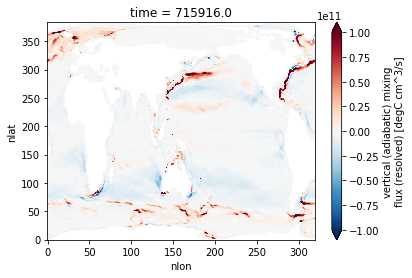

In [20]:
f_adi = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,"HDIFB_"+TRACER)
#*****************************************************************************#
temp_adi_vmix = tracer_budget_adi_vmix(f_adi, TRACER, vol3d, klo,khi,tlo,thi)
temp_adi_vmix.isel(time=5).plot(vmin=-1e11,vmax=1e11,cmap="RdBu_r");
temp_adi_vmix

## Surface fluxes

Compute tracer surface fluxes

Obs.: fluxes positive are down!

In [21]:
def tracer_budget_sflux (f_flx, TRACER, var_name, area2d, tlo=912, thi=1032):
    """
    compute domain-specific maps of tracer surface fluxes
    
    Note: fluxes positive are down!
 
    based on tracer_budget_srf_flux.ncl
    """
    # read tracer associate variable
    ds = read_cesm_pop (f_flx, 60)
    rho_sw = ds["rho_sw"]              # density of saltwater (g/cm^3)
    rho_sw = rho_sw * 1.e-3             # (kg/cm^3)
    cp_sw = ds["cp_sw"]                # spec. heat of saltwater (erg/g/K)
    cp_sw = cp_sw * 1.e-7 * 1.e3        # (J/kg/K)
    rho_cp = rho_sw * cp_sw             # (J/cm^3/K)
    latvap = ds["latent_heat_vapor"]   # lat heat of vaporiz. (J/kg)
    latfus = ds["latent_heat_fusion"]  # lat heat of fusion (erg/g)
    latfus = latfus * 1.e-7 * 1.e3      # (J/kg)
    # scale factors
    if var_name in ["SHF", "QFLUX", "SENH_F", "LWDN_F", "LWUP_F", "SHF_QSW", "MELTH_F"]:
        scale_factor = 1.e-4 * (1./rho_cp)          #W/m^2 -> degC cm/s
    elif var_name in ["SNOW_F","IOFF_F"]:
        scale_factor = -latfus*1.e-4 * (1./rho_cp)  #kg/m^2/s -> degC cm/s
    elif var_name is "EVAP_F":
        scale_factor = latvap*1.e-4 * (1./rho_cp)   #kg/m^2/s -> degC cm/s
    else :
        scale_factor = 1.
    
    if TRACER == "TEMP":
        units = "degC cm^3/s"
    else:
        units = "PSU cm^3/s"
        
    FIELD = ds[var_name].isel(time=slice(tlo,thi))
    var1 = FIELD * scale_factor
    var_sflux_map = var1*area2d
    long_name = "vertical flux across sea surface"
    attr = {"long_name" : long_name, "units" : units}
    var_sflux_map.attrs = attr
    var_sflux_map.name = TRACER.lower() + "_" + var_name 
    var_sflux_map = var_sflux_map.drop(("ULONG","ULAT"))
    return var_sflux_map

In [22]:
#*****************************************************************************#
# fluxes terms
flx = "QFLUX"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_qflux = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

flx = "SENH_F"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_senh_f = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

flx = "LWDN_F"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_lwdn_f = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

flx = "LWUP_F"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_lwup_f = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

flx = "MELTH_F"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_melth_f = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

flx = "SHF_QSW"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_shf_qsw = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

flx = "EVAP_F"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_evap_f = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

flx = "SNOW_F"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_snow_f = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

flx = "IOFF_F"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_ioff_f = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

flx = "SHF"
f_flx = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,flx)[0]
temp_shf = tracer_budget_sflux(f_flx, TRACER, flx, area2d, tlo, thi)

## Tendency from KPP non local mixing term

In [23]:
def tracer_budget_kpp_src (f_kpp, TRACER, vol3d,\
                           klo=1, khi=25, tlo=912, thi=1032):
    """
    compute tendency from KPP non local mixing term
    """
    var_name = "KPP_SRC_"+TRACER
    # read tracer associate variable
    ds = read_cesm_pop (f_kpp, 60)
    KPP_SRC = ds[var_name].isel(time=slice(tlo,thi))
    #KPP_SRC = KPP_SRC.where(KPP_SRC != 0.)
    # compute temp flux
    temp_kpp_src = tracer_budget_var3d_zint_map(KPP_SRC,vol3d,klo,khi)
    return temp_kpp_src

## Total surface flux

[########################################] | 100% Completed |  8.9s
[########################################] | 100% Completed |  8.0s


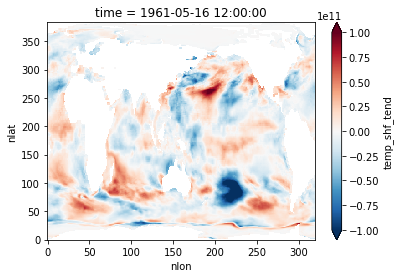

In [24]:
#*****************************************************************************#
# total surface flux
f_kpp = get_filemember (dir_lens,COMPSET,freq,realm,ens_str,"KPP_SRC_"+TRACER)[0]
temp_kpp_src = tracer_budget_kpp_src (f_kpp, TRACER, vol3d, klo, khi, tlo, thi)
temp_shf_tend = temp_qflux +  temp_senh_f + temp_lwdn_f + temp_lwup_f + \
    temp_melth_f + temp_shf_qsw + temp_evap_f + temp_snow_f + temp_ioff_f + temp_kpp_src
temp_shf_tend.name = "temp_shf_tend"
temp_shf_tend_anom = rmMonAnnCyc(pop_decode_time(temp_shf_tend,time_bound))
with ProgressBar():
    temp_shf_tend_anom.isel(time=5).plot(vmin=-1e11,vmax=1e11,cmap="RdBu_r");